# Load Dataset

In [17]:
import pandas as pd
import os
import numpy as np
from pprint import pprint
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def tryconvert(x, to_type, default):
  '''
  Try convert `x` to a type specified by `to_type` function. 
  Returns `default` value if casting is not possibile 
  '''
  try:
    return to_type(x)
  except:
    return default

def load_data(directory, nrows=None, usecols=None, converters=None, dtype=None):
# Read each CSV file in dir "path/to/root_dir"
    dfs = []
    for file in Path(directory).glob('**/*.csv'):
        dfs.append(pd.read_csv(file, nrows=nrows, usecols=usecols, converters=converters, dtype=dtype))
    # Put the dataframes to a single dataframe
    df = pd.concat(dfs, ignore_index=True)
    return df

benign_dir = os.path.join(os.getcwd(), 'dataset', 'Benign')
malware_dir = os.path.join(os.getcwd(), 'dataset', 'Malware')

usecols = [" Total Length of Bwd Packets", " Fwd Packet Length Std", " Bwd Packet Length Min", " Bwd Packet Length Std", " Flow IAT Mean", " Flow IAT Min", "Init_Win_bytes_forward", " Init_Win_bytes_backward", " min_seg_size_forward", " Label"]

# Define column datatype when reading CSVs
converters = dict(itertools.product(usecols, [lambda x: tryconvert(x, float, np.nan)]))
converters[" Label"] = lambda x: x

# Load data
N_rows = 10
benign_df = load_data(benign_dir, nrows=N_rows, usecols=usecols, converters=converters)
malware_df = load_data(malware_dir, nrows=N_rows, usecols=usecols, converters=converters)

df = pd.concat([benign_df, malware_df], ignore_index=True)

# shuffle dataset
#df = df.sample(frac=1).reset_index(drop=True)

# trim columns labels
df.columns = df.columns.str.strip()

# Drop rows which contain NaN values
df.dropna(inplace=True)

# Drop empty label rows
df.drop(df[df["Label"] == ''].index, inplace = True)

# Change Label values in "MALWARE" or "BENIGN"
df["Label"] = df["Label"].apply(lambda x: 'MALWARE' if x != 'BENIGN' else x)
df

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Label
0,170.0,231.517458,0.0,85.0,35088.833333,25.0,65535.0,16.0,32.0,BENIGN
1,0.0,0.000000,0.0,0.0,142284.000000,142284.0,1386.0,-1.0,32.0,BENIGN
2,0.0,0.000000,0.0,0.0,18765.000000,716.0,2290.0,426.0,32.0,BENIGN
3,0.0,0.000000,0.0,0.0,18369.500000,27.0,1419.0,362.0,32.0,BENIGN
4,0.0,0.000000,0.0,0.0,289279.000000,289279.0,1641.0,-1.0,32.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...
20215,0.0,0.000000,0.0,0.0,37352.000000,37352.0,1548.0,391.0,32.0,MALWARE
20216,357.0,213.042249,0.0,178.5,8715.500000,23.0,65535.0,59.0,32.0,MALWARE
20217,0.0,0.000000,0.0,0.0,9171.000000,9171.0,1386.0,-1.0,32.0,MALWARE
20218,223.0,150.111070,0.0,111.5,12298.833333,40.0,65535.0,15544.0,20.0,MALWARE


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20220 entries, 0 to 20219
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total Length of Bwd Packets  20220 non-null  float64
 1   Fwd Packet Length Std        20220 non-null  float64
 2   Bwd Packet Length Min        20220 non-null  float64
 3   Bwd Packet Length Std        20220 non-null  float64
 4   Flow IAT Mean                20220 non-null  float64
 5   Flow IAT Min                 20220 non-null  float64
 6   Init_Win_bytes_forward       20220 non-null  float64
 7   Init_Win_bytes_backward      20220 non-null  float64
 8   min_seg_size_forward         20220 non-null  float64
 9   Label                        20220 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [23]:
df.describe()

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward
count,2.022000e+04,20220.000000,20220.000000,20220.000000,2.022000e+04,2.022000e+04,20220.000000,20220.000000,20220.000000
mean,3.613802e+04,50.200339,1.352522,78.997566,4.747411e+05,1.815228e+05,15600.606281,1121.342631,30.787537
std,5.141180e+05,108.177913,32.826314,193.705287,2.164519e+06,1.648089e+06,26491.548105,4905.781892,3.646283
min,0.000000e+00,0.000000,0.000000,0.000000,2.000000e+00,-1.100000e+01,-1.000000,-1.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,9.393667e+03,4.000000e+01,1418.000000,-1.000000,32.000000
50%,0.000000e+00,0.000000,0.000000,0.000000,3.654700e+04,8.705000e+02,1595.000000,192.000000,32.000000
75%,0.000000e+00,29.698485,0.000000,0.000000,5.940077e+04,3.697025e+04,4117.000000,391.000000,32.000000
max,2.864423e+07,960.251009,1460.000000,938.039292,6.793382e+07,6.793382e+07,65535.000000,65535.000000,44.000000


<Axes: xlabel='Label', ylabel='# occurrences'>

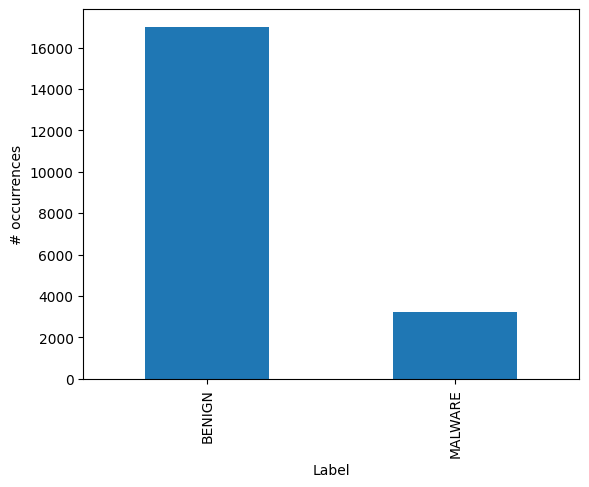

In [3]:
df["Label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="# occurrences"
)

<Axes: ylabel='Label'>

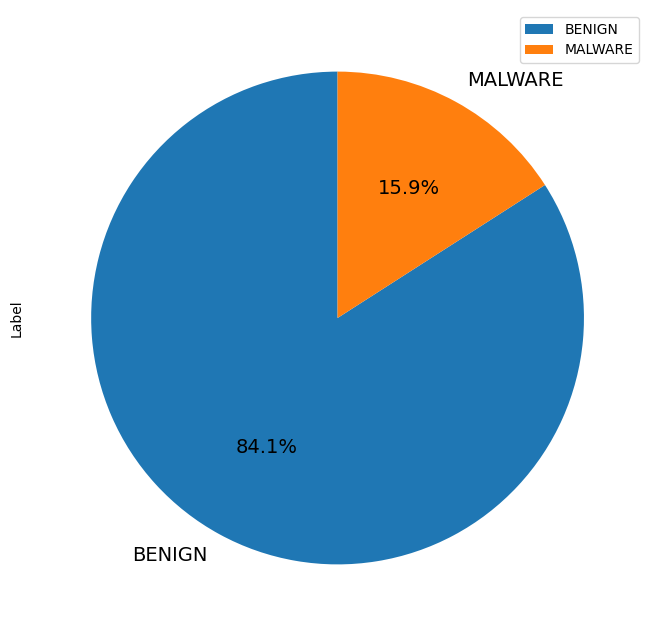

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

df["Label"].value_counts().plot(
    kind="pie",
    autopct='%1.1f%%',
    startangle=90,
    shadow=False,
    legend=True,
    fontsize=14,
    ax=ax
)

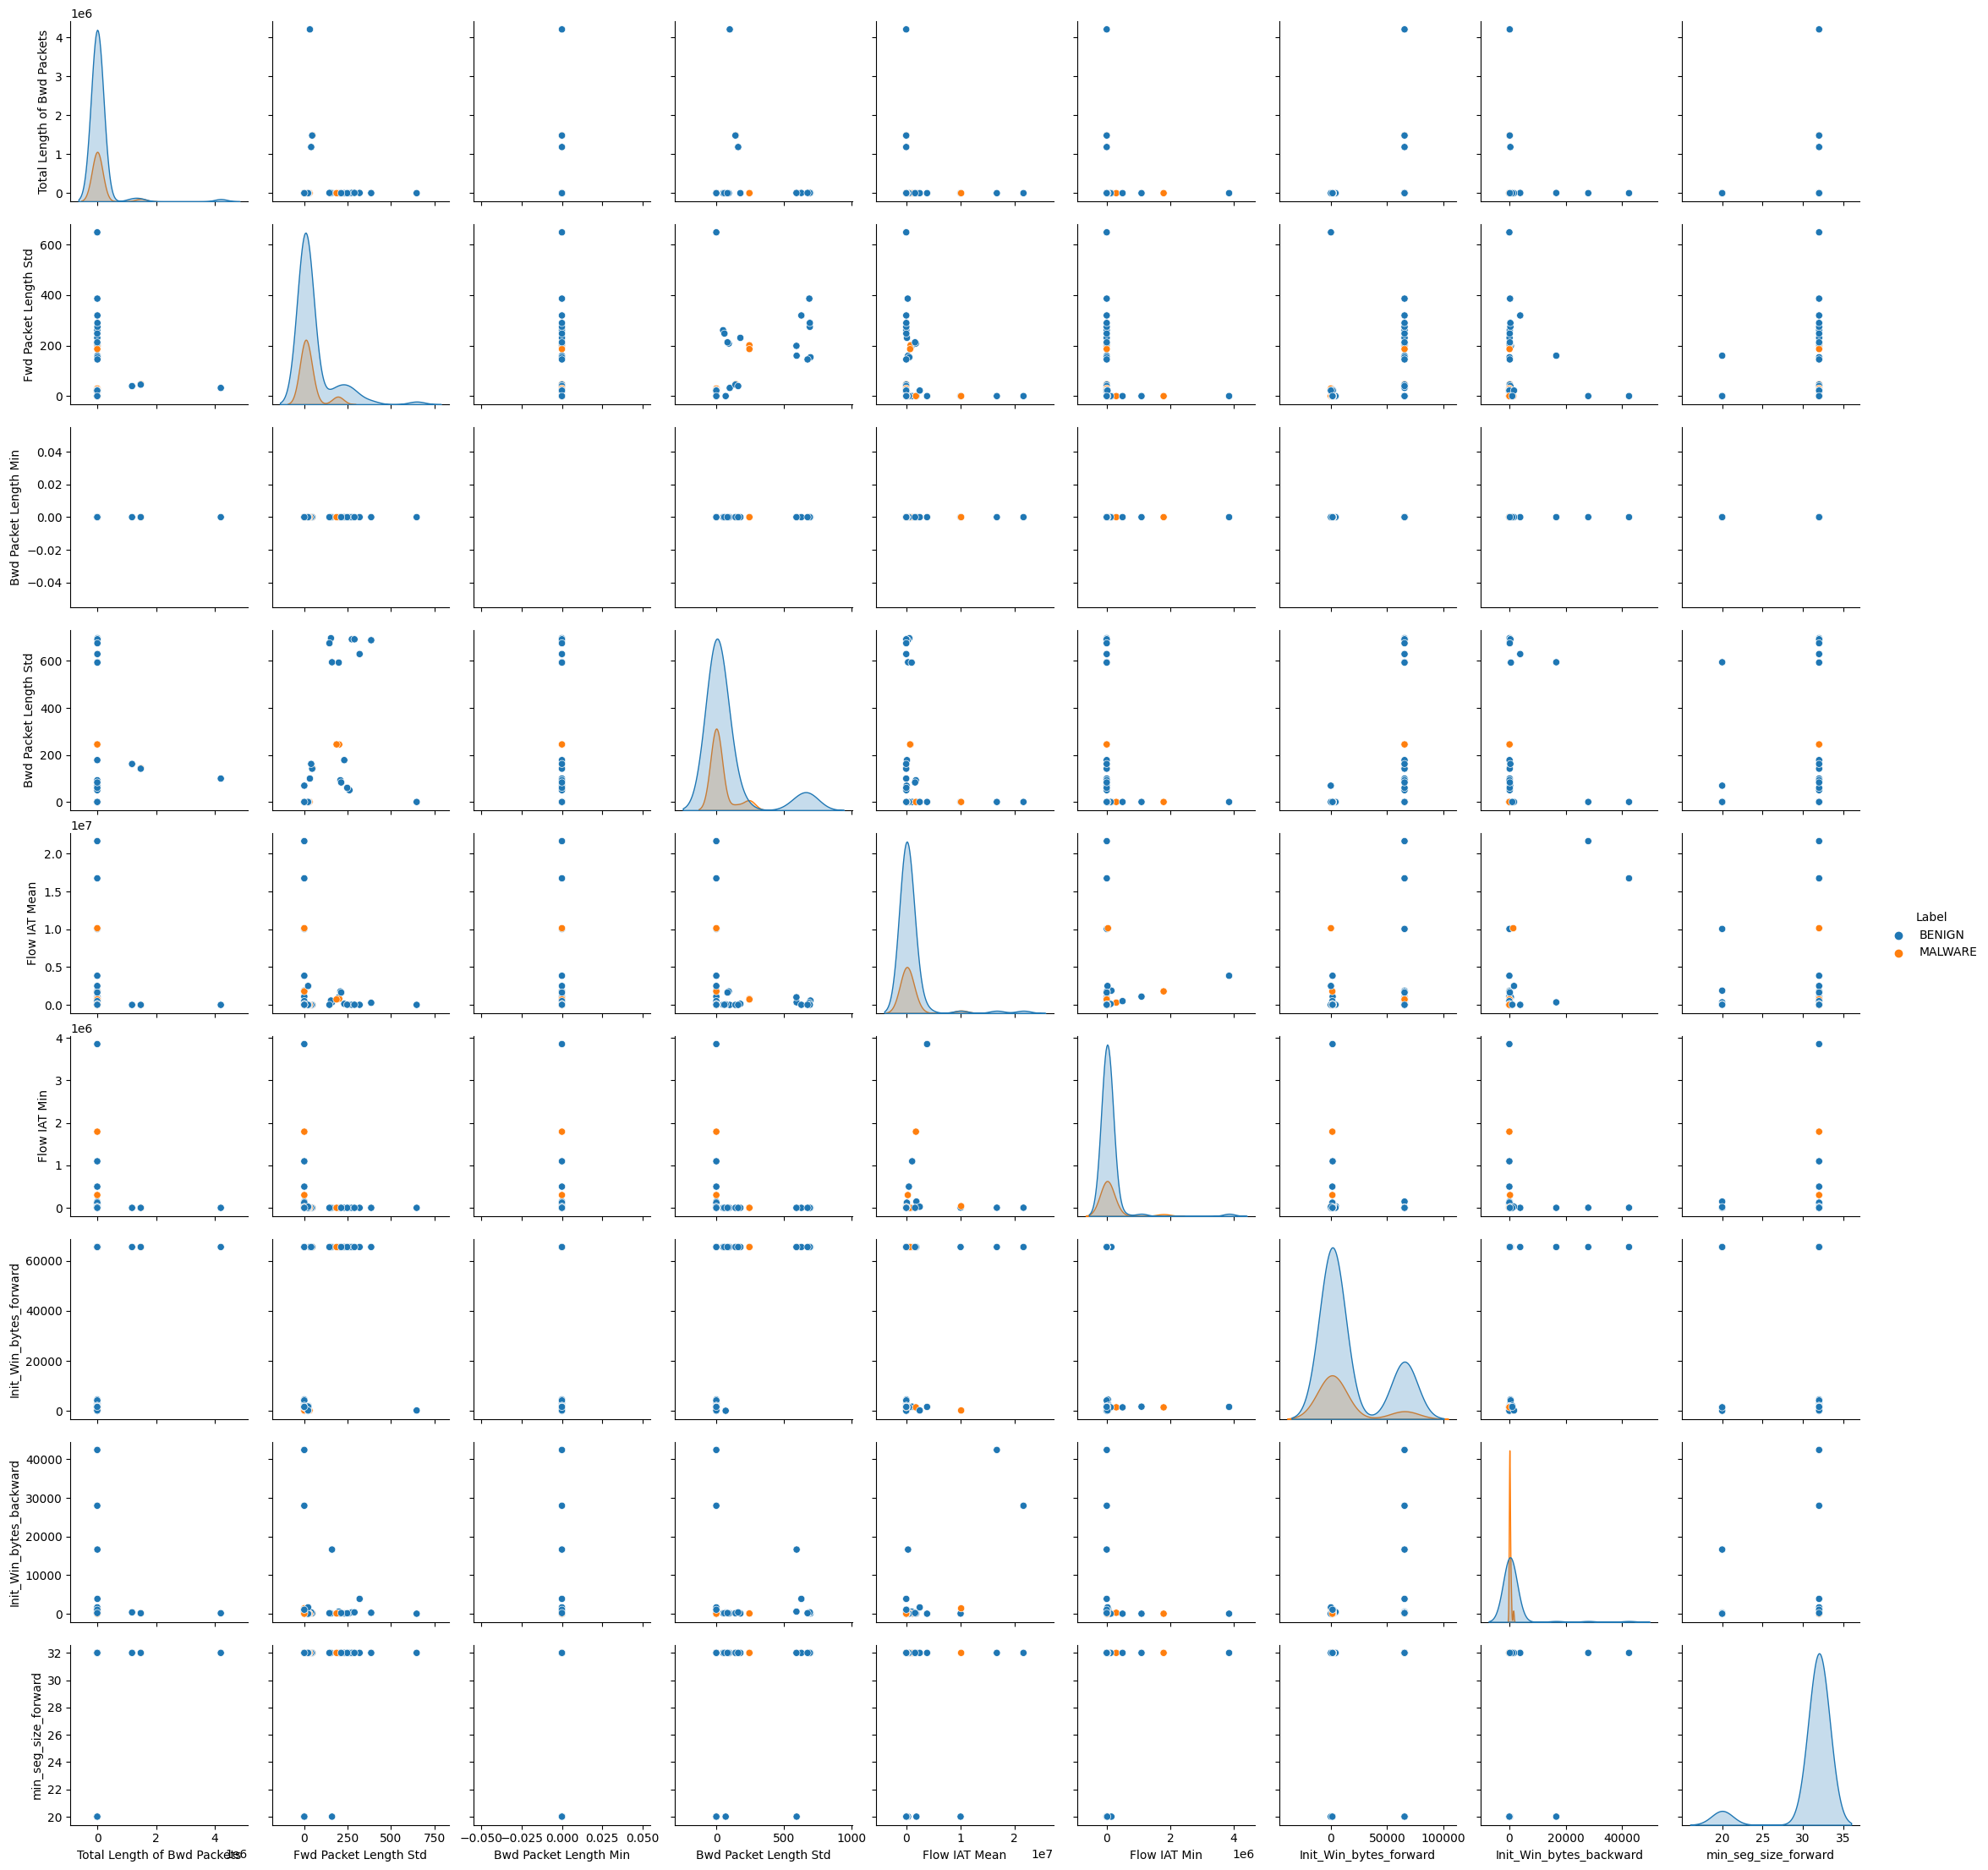

In [25]:
df = df.sample(frac=1).reset_index(drop=True)
sns.pairplot(df.iloc[:100], hue="Label")

# Data Preprocessing

In [4]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    if "Source IP" in df.columns:
        df['Source IP'] = label_encoder.fit_transform(df['Source IP'])
    if "Flow ID" in df.columns:
        df['Flow ID'] = label_encoder.fit_transform(df['Flow ID'])
    if "Destination IP" in df.columns:
        df['Destination IP'] = label_encoder.fit_transform(df['Destination IP'])

    if "Timestamp" in df.columns:
        # drop column Timestamp
        df = df.drop(['Timestamp'], axis=1)    
    return df

df = data_preprocessing(df)
df.shape

(20220, 10)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Label'], axis=1),
    df['Label'],
    test_size=0.4,
    random_state=42
)

X_train.shape, X_test.shape

((12132, 9), (8088, 9))

In [6]:
X_train.head()

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward
4231,0.0,17.897858,0.0,0.0,106767.0,867.0,1594.0,-1.0,32.0
12571,0.0,0.000000,0.0,0.0,52.0,52.0,324.0,-1.0,32.0
306,0.0,0.000000,0.0,0.0,43.0,43.0,509.0,-1.0,32.0
8642,0.0,0.000000,0.0,0.0,36576.0,36576.0,2089.0,350.0,32.0
17895,0.0,29.698485,0.0,0.0,28.0,28.0,114.0,-1.0,32.0


In [17]:
y_train.head()

606964      BENIGN
2065209    MALWARE
2072321    MALWARE
1932879    MALWARE
484794      BENIGN
Name: Label, dtype: object

# Valutazione

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')


# Decision Tree

In [9]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

[Text(0.5, 0.875, 'Init_Win_bytes_backward <= 250.5\ngini = 0.271\nsamples = 12132\nvalue = [10173, 1959]\nclass = BENIGN'),
 Text(0.25, 0.625, 'Init_Win_bytes_backward <= 175.5\ngini = 0.307\nsamples = 6304\nvalue = [5111, 1193]\nclass = BENIGN'),
 Text(0.125, 0.375, 'Flow IAT Mean <= 13.5\ngini = 0.291\nsamples = 5711\nvalue = [4702, 1009]\nclass = BENIGN'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Flow IAT Mean <= 36041.0\ngini = 0.428\nsamples = 593\nvalue = [409, 184]\nclass = BENIGN'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Init_Win_bytes_forward <= 32.5\ngini = 0.228\nsamples = 5828\nvalue = [5062, 766]\nclass = BENIGN'),
 Text(0.625, 0.375, 'Flow IAT Mean <= 3622170.75\ngini = 0.499\nsamples = 25\nvalue = [13, 12]\nclass = BENIGN'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Flow IAT Min <= 36974.0\ngini = 0

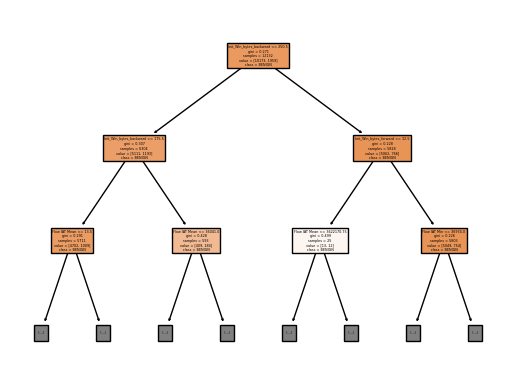

In [10]:
tree.plot_tree(decision_tree, filled=True, class_names=decision_tree.classes_, feature_names=X_train.columns, max_depth=2)

              precision    recall  f1-score   support

      BENIGN       0.89      0.87      0.88      6827
     MALWARE       0.38      0.43      0.40      1261

    accuracy                           0.80      8088
   macro avg       0.64      0.65      0.64      8088
weighted avg       0.81      0.80      0.81      8088



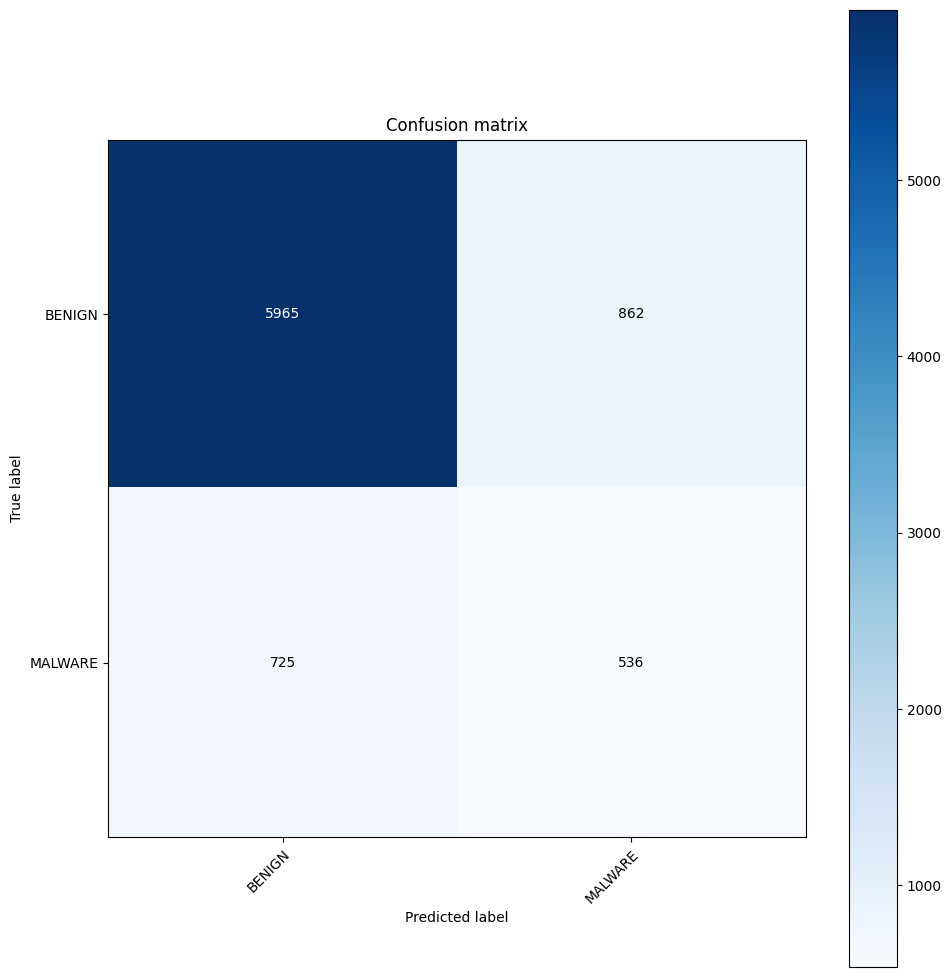

In [11]:
valuate(decision_tree, X_test, y_test)

In [12]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    decision_tree,
    X_train,
    y_train,
    cv=10,
    scoring=['precision_macro', 'recall_macro']
)

In [ ]:
print(f'{10}-fold cross validation:')
print('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))

10-fold cross validation:
Precision: 0.75 (+/- 0.01)
Recall: 0.75 (+/- 0.00)


# KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

      BENIGN       0.62      0.66      0.64    484144
     MALWARE       0.55      0.51      0.53    391694

    accuracy                           0.59    875838
   macro avg       0.59      0.58      0.58    875838
weighted avg       0.59      0.59      0.59    875838



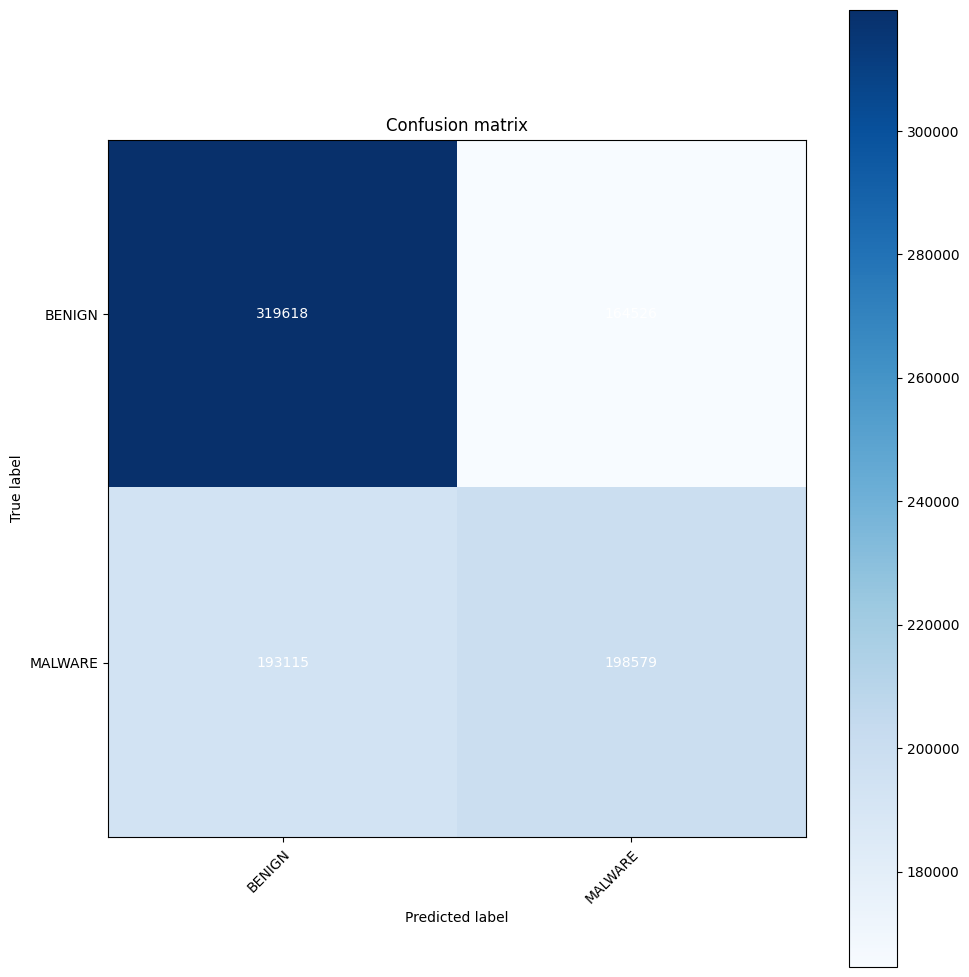

In [30]:
valuate(knn, X_test, y_test)

# Support Vector Machine

In [31]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

C=1.0
models = (
    # svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=1000, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    #svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = [clf.fit(X_train, y_train) for clf in models]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
              precision    recall  f1-score   support

      BENIGN       0.57      0.31      0.40      2311
     MALWARE       0.42      0.69      0.52      1689

    accuracy                           0.47      4000
   macro avg       0.50      0.50      0.46      4000
weighted avg       0.51      0.47      0.45      4000

SVC:
              precision    recall  f1-score   support

      BENIGN       0.58      1.00      0.73      2311
     MALWARE       1.00      0.01      0.02      1689

    accuracy                           0.58      4000
   macro avg       0.79      0.51      0.38      4000
weighted avg       0.76      0.58      0.43      4000



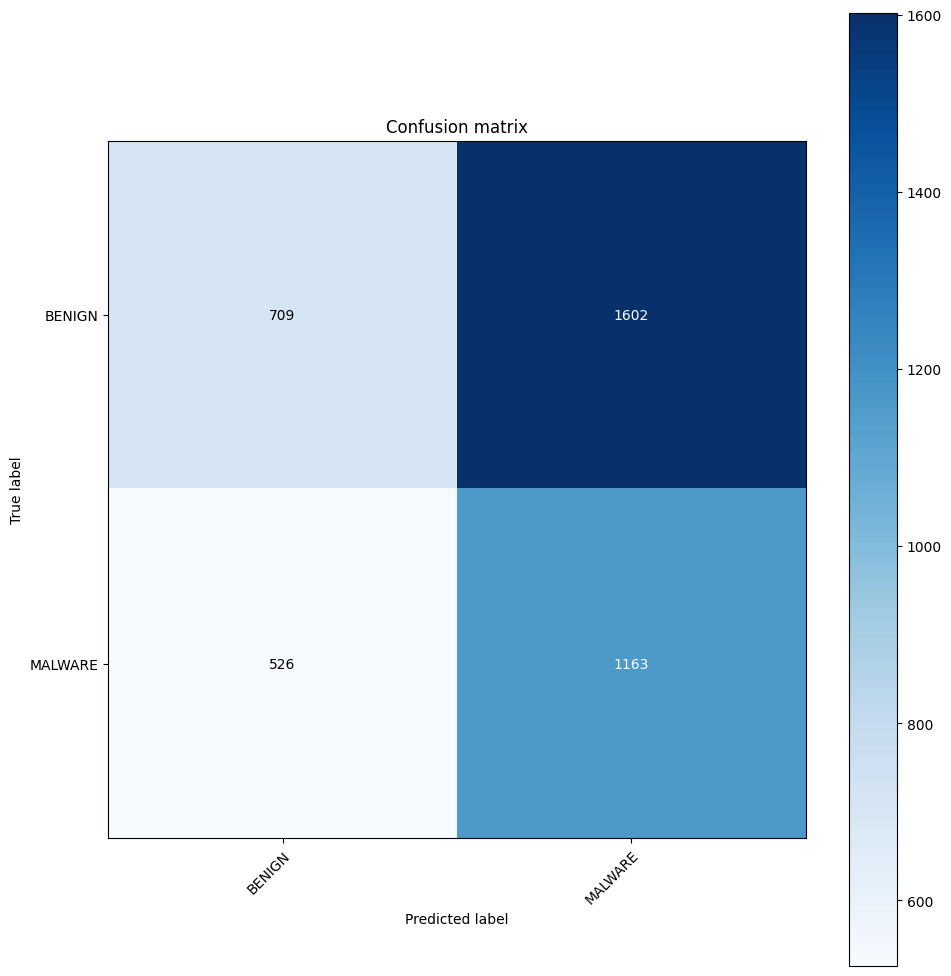

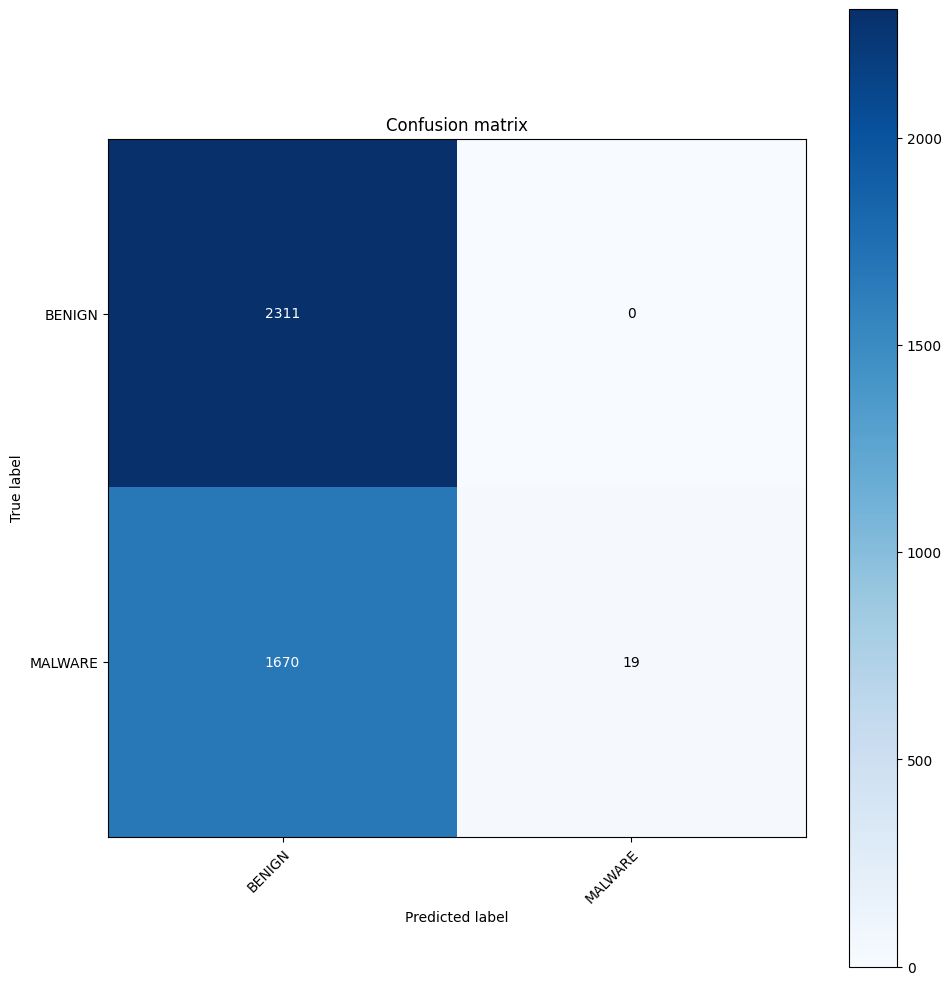

In [ ]:
# valuate models

for clf in models:
    # print scores 
    print(f'{clf.__class__.__name__}:')
    valuate(clf, X_test, y_test)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      BENIGN       0.59      0.91      0.71     67991
     MALWARE       0.55      0.15      0.24     51410

    accuracy                           0.58    119401
   macro avg       0.57      0.53      0.47    119401
weighted avg       0.57      0.58      0.51    119401



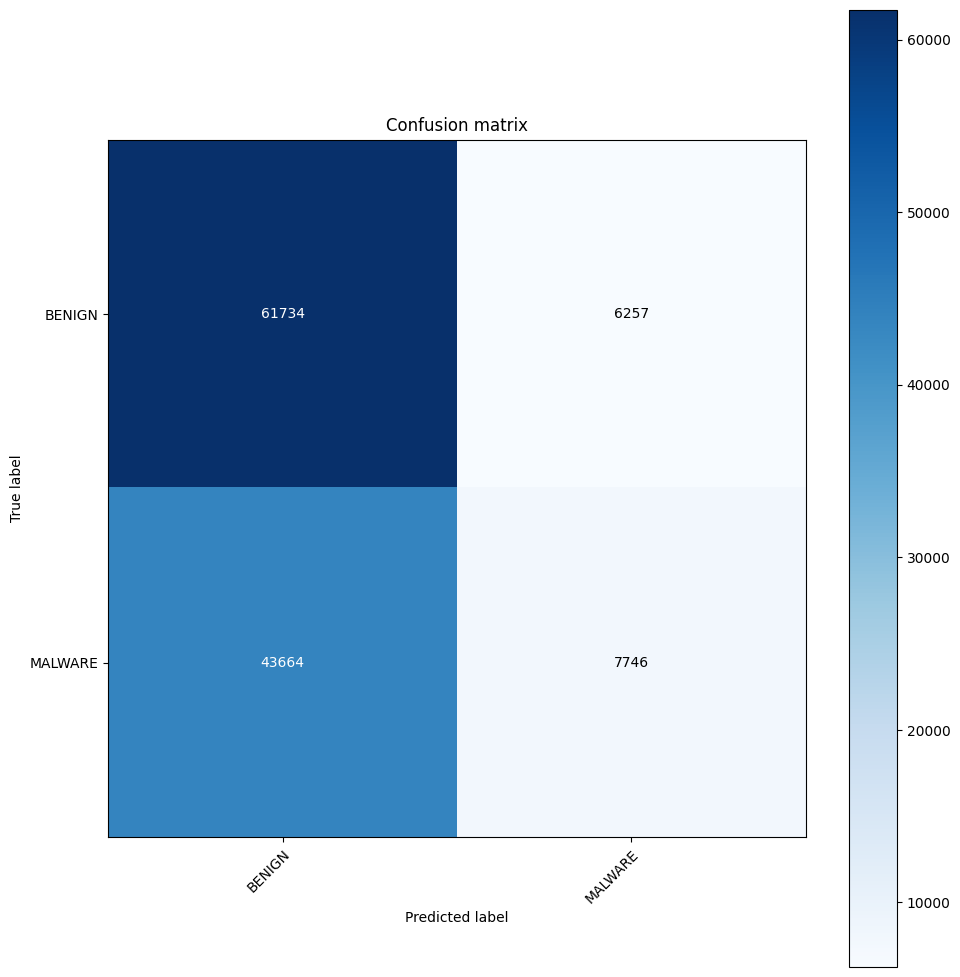

In [ ]:
valuate(logistic_classifier, X_test, y_test)

# Gaussian Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.59      0.89      0.71     67991
     MALWARE       0.58      0.19      0.29     51410

    accuracy                           0.59    119401
   macro avg       0.59      0.54      0.50    119401
weighted avg       0.59      0.59      0.53    119401



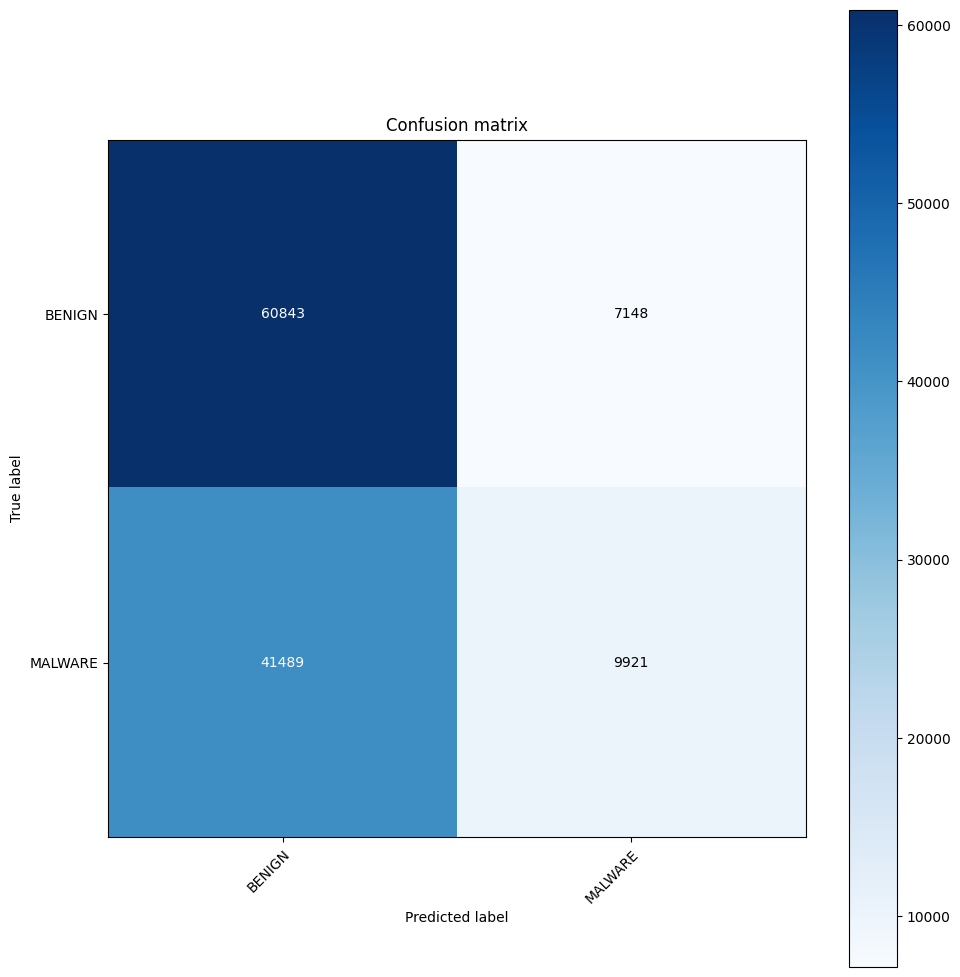

In [ ]:
valuate(lda_classifier, X_test, y_test)

# MultiLayer Perceptron

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    print("Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!")
    device = torch.device("cpu")

Using device: cpu


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class NetworkDataset(Dataset):
    def __init__(self, data, target):
        self.data = data.to_numpy()
        #self.data = data
        self.target = label_encoder.fit_transform(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


train_dataset = NetworkDataset(X_train, y_train)
test_dataset = NetworkDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkNN(nn.Module):

    def __init__(self):
        super(NetworkNN, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 5)
        self.fc3 = nn.Linear(5, 2)
        self.logits = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.logits(x)
        return x

model = NetworkNN()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1} loss: {running_loss / len(dataloader)}')

In [ ]:
train(model, train_dataloader, criterion, optimizer, epochs=10)

Epoch 1 loss: 2.636086460457141
Epoch 2 loss: 0.688989948655674
Epoch 3 loss: 0.683590408668811
Epoch 4 loss: 0.6835964393641276
Epoch 5 loss: 0.6836031497951575
Epoch 6 loss: 0.6835981339546304
Epoch 7 loss: 0.6836013377202583
Epoch 8 loss: 0.6836016099552633
Epoch 9 loss: 0.683603422370882
Epoch 10 loss: 0.6836020034651706


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for _ in range(2))
class_total = list(0. for _ in range(2))

model.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.683236

Test Accuracy of     0: 100% (68091/68091)
Test Accuracy of     1:  0% ( 2/51310)

Test Accuracy (Overall): 57% (68093/119401)
